# Chains
Now, lets build on top of what you have learned so far.  We will build a **chain** that combines 4 concepts.  In LangChain you can leverage LangChain Expression Language, which is a declarative way to chain LangChain components.

In LangChain, a **Chain** is a sequence of steps or components that work together to accomplish a task. Here's a layman's explanation:

Think of a Chain like a recipe or a workflow. It's a series of instructions or actions that you want the language model to follow.

Each step in the Chain is called a "Runnable". This could be things like:

- Calling a language model to generate some text
- Retrieving information from a database or API
- Parsing or transforming the output of a previous step

![chain](../../images/chain.jpg)

# Messages
LLMs use messages, which we covered in [Module 1](../1-module/2-Messages-Streaming.ipynb).  Messages are used to capture different roles within the conversation.

LangChain supports various message types, such as **HumanMessage**, **AIMessage**, **SystemMessage** and **ToolMessage**.  These represent a message from the user, from LLM for the model to instruct behavior, and from a tool call.

1. We will start by creating a list of messages.

Each message can be suppied with a few things:
- **content** - content of the message
- **name** - optionally, a message author
- **response_metadate** - optionally, a dict of metadata (e.g., often populated by the model provider for **AIMessages**)

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching prompt engineering?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Rick"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the Plan and Solve pattern", name="Lance"))

for m in messages:
    m.pretty_print()

# Large Language Models
LLMs can use a sequence of messages as input and message types as previously mentioned.  We will leveage Azure OpenAI as an example.

Let's check that your **AZURE_OPENAI_API_KEY** is set and if not you will be asked to enter it.

In [2]:
import os, getpass
from langchain_openai import AzureChatOpenAI

from dotenv import load_dotenv
import os
from pathlib import Path

# Get root directory path
root_dir = Path().absolute().parent.parent
env_path = root_dir / '.env'

# Load .env from root
load_dotenv(dotenv_path=env_path)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("AZURE_OPENAI_API_KEY")
# Access variables
api_key = os.getenv('AZURE_OPENAI_API_KEY')

print(f"API Key: {  api_key[:4] + '*' * 28 + api_key[-4:] }")

API Key: 8PVz****************************Isv1


Let's load a model and invoke it with our list of messages.  We can see that the results is an **AIMessage** with specific **response_metadata**.

In [3]:
from langchain_openai import AzureChatOpenAI
llm = AzureChatOpenAI(model_name="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

Now let's take a look at the result.

In [4]:
result

AIMessage(content='One of the best places to see orcas in the United States is the San Juan Islands in Washington State. The waters around these islands are known for having resident orca pods, particularly during the summer months. The southern resident killer whales, which are an endangered population, are often seen in this area.\n\nAnother prime location is the Puget Sound, which also offers opportunities to see these magnificent creatures, especially during their feeding season.\n\nFor those on the East Coast, while orcas are less common, there have been occasional sightings off the coast of Maine.\n\nWhen planning a trip to see orcas, consider joining a guided whale-watching tour, as these are led by experts who know the best spots and times to see orcas while ensuring minimal disturbance to the animals.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 67, 'total_tokens': 221, 'completion_tokens_details': None, '

Now, let's take a look at the **response_metadata**.

In [ ]:
result.response_metadata


Notice how the response_metadata has all sorts of valuable information (e.g. token usage etc.)!

# Tools
Tools are useful whenever you want to have a model interact with external systems.  External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.  We we **bind** an API, for example, as a tool we have provided the model with awareness of the required **input schema**.

The model will choose to call a tool base dupon the natural language input from the user, and it will return an output that adheres to the tool's schema.  Most LLM providers support tool calling and the [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is fairly simple.

You can pass any Python **function** into **Model.bind_tools(function)**. 

![tool calling](../../images/tool-calling.jpg)

Let's take a look at a simple example example **tool calling**.  This example is a little different than the example found in the [Messages-Streaming] example found in **module 1**.  

We will create a **multiply** function as our tool.

In [6]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input e.g., **"What is 2 multipled by 3" - we will see a tool called returned.

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

   ~~~
      {'arguments': '{"a":2,"b":3}', name': 'multiply'}
   ~~~

In [14]:
import json
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZDXzr9C2Wi7ktwgApaZcOFjr', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 62, 'total_tokens': 79, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_04751d0b65', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-121a001f-7f59-4b7d-b056-32c0b774763a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_ZDXzr9C2Wi7ktwgApaZcOF

In [13]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_D5knnjVW6yfq1Y9UxPaTeQEx',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

# Using Messages as State
With these foundations and knowledge in place, we can now use **messages** in our graph state.

Let's define our state, **MessagesState**, as a **TypedDict** with a single key: **messages**.

**messages** is simply a list of messages, as we demostrated eariler (e.g., HumanMessage, etc).

In [15]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

# Reducers
We have a minor problem!  As we mentioned eariler, each node will return a new value for our state key **messages**, so this means our new value will **override** the prior **messages** state key!

As our graph runs, we want to **append** messages to our **messages** state key.  We will use **reducer functions** to address this.  Please read the **Important Notes about Reducers** section below.

Reducers allow us to specify how state updates are performed.  If no reducer functiuon is explicitly specified then it is assumed that all updates to that key **should override it**!

But, to append messages, we can use the pre-built **add_messagfes** reducer.  This ensures that any **messages** are appended to the existing list of **messages**.

We simply need to annotate **messages** key with the **add_messages** reducer function as metadata. 

## Important Notes about Reducers

We can use [**reducer functions**](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.  Reducers are key to understanding how updates from the nodes are applied to the **State**.  Each key in the **State** has its own independent reducer function.    There are a few different types of reducers, starting with the default tyhpe of reducer:

Please take a look at the [**reducers**](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) documentation for a detailed explaination.

Ok, so let's create a custom state object with two **keys** one called **some_place_holder** which has no **reducer** specified, as a result this is treated as an update to the state, so it is overridden each time.  

But, notice how we use an **Annotated** type to specify a reducer function (**operator.add_messages**) for the **messages** key.  If you simply used the **operator.add** as the reducer for **messages** this would allow you to allow append messages only.  By using the (**operator.add_messages**) this allows us to add new messages as well as update existing messages.

In [19]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    some_place_holder: str
    messages: Annotated[list[AnyMessage], add_messages]

Having a list of messages in graph state is so common, LangGraph has a pre-built **MessagesState**!

**MessagesState** is defined as:
- With a pre-built single messages key
- This is a list of **AnyMessage** objects
- It uses the **add_messages** reducer

We will usually use **MessagesState** because it is less verbose than defining a customer **TypedDict**, as shown abnove.

Let's take a look at using the pre-built **MessagesState*.

In [17]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    some_place_holder: str


Let's go a bit deeper and see how the **add_messages** reducer wrks in isolation.

In [ ]:
from typing import Annotated
from pprint import pprint
from langgraph.graph.message import add_messages
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on mountain biking.", name="Rick")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
result = add_messages(initial_messages , new_message)
for m in result:
    m.pretty_print()

As we can see, the new message is added to the **initial_messages**.

# Our Graph
Now, let's use the **MessagesState** with a graph.  Notice how we did not sub-class the **MessagesState** pre-built state object.  We simply pass it to the **tool_calling_llm** function.  

## What is happening here?
1. The MessagesState object is passed to the function and by **default** it has a **Messages** key with default **reducer** that looks like this:

   ~~~
      messages: Annotated[list[AnyMessage], add_messages]
   ~~~

Which gives us the default ability to add or update messages in the **MessagesState** object as explained eariler.

2. Notice that we are invoking our LLM with **llm_with_tools.invoke(state["messages"])**.  This results in the **messages** being passed to the LLM and the response being adding to the **messages** key as a new **AIMessage**!  

Very important to note that the have not invoked the *graph* yet, so the tool has **not** been called yet.

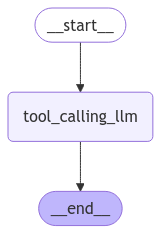

In [27]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's pass in a *"Hello"* and invoke our graph and we will see the the LLM repsonse without anyt tool calls.

In [28]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


Now, let's in a prompt that will result in the LLM choosing a tool to use when it determines that the input or taks requires the functionality provided by a tool.

In [29]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_t6fBklbM6n2cneKu1ucPDOzD)
 Call ID: call_t6fBklbM6n2cneKu1ucPDOzD
  Args:
    a: 2
    b: 3
